<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp09_Compare_Manifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* After Training, Compare Manifold
* Add 
    * just plot Manifold before training 
    * like <a href='https://www.notion.so/youngjoenlee/01-Zero-day-malware-detection-using-transferred-generative-adversarial-networks-based-on-deep-autoe-f8181f46b1234d91a6dfc9b98a758168'>this(My Notion)</a>
* ✅ Check Point
    * Keep training Exp05
        * After Epoch 10, Train it
        * Reduce Learning rate: 1e-5 to 1e-3


## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


## 00. Check GPU & Mount Drive
* ! nvidia-smi
* autoreload
* google.colab drive module

In [1]:
 ! nvidia-smi

Wed Jul 22 08:04:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [10]:
%matplotlib inline 
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
# from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms  # for data preprocessing
from torchvision.utils import save_image

## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [11]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
# use: torchvision.datasets.ImageFolder()
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [12]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [13]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

### Train, Test Split

In [14]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

# train_test split
# use: torch.utils.data.random_split()
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


### Make Train, Test Loader

In [16]:
# make train_loader & test_loader
batch_size = 16

train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
# In this(Exp09)_we compare test_loader_10 before & after training -20.07.09.Thur-
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [18]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 2,  3,  2, 18,  3, 18,  1,  3,  2,  2, 24, 13,  2, 18,  2, 21])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Allaple.A Allaple.L Allaple.A Rbot!gen Allaple.L Rbot!gen Agent.FYI Allaple.L Allaple.A Allaple.A Yuner.A Lolyda.AA2 Allaple.A Rbot!gen Allaple.A Swizzor.gen!I 


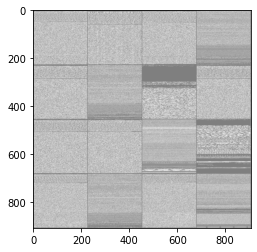

In [19]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

일단 출력을 해보고

In [20]:
for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
    print(i, data.shape, _.shape)

0 torch.Size([1868, 1, 224, 224]) torch.Size([1868])


출력결과: 음... 이정도면 괜찮군요!

Just use this code?

======================================== params ========================================
Z_embedded.shape: (1868, 2)
label.shape: (1868,)


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


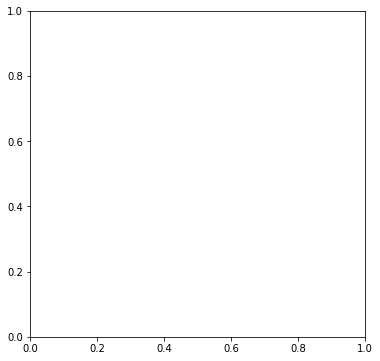

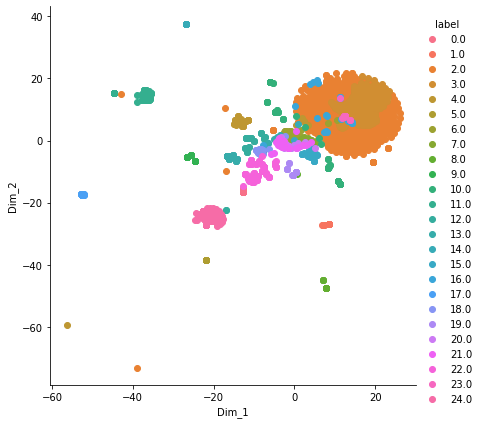

In [ ]:
# make empty 

for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
    # data = data.to(device)
    # recon_batch, mu, logvar, z = model(data)
# save latent_vector per 10 Epochs
    # latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                        # latent_vector_size: (num_of_data, 100)
    # color_palette = _.detach().cpu().clone().numpy()

    original_vector = data.detach().cpu().clone().numpy()
    print(original_vector.shape)
    latent_vector = np.reshape(original_vector, (1868, 224*224))  # Exp09_latent_vector ==> not latent vector
                                                                  # just for checking manifold
                                                                  # 이 코드가 이해가 안가네... reshape을 왜 해줬지?
                                                                  # 위의 Cell에서 print를 해보면 test_loader로부터 불러온 데이터의 shape이
                                                                  # [1868, 1, 224, 224]이기 때문이다.
                                                                  # TSNE알고리즘을 사용하기 위해서는 (Num_data, Num_features)의 형태로 변환해주어야 한다
    print(latent_vector.shape)
    color_palette = _.detach().cpu().clone().numpy()

    # plot original test_data data
    # t-SNE for Dimensionality reduction
    Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

    x = Z_embedded[:, 0]
    y = Z_embedded[:, 1]
    label = color_palette
    # label[10:12] = 0  # make sure there are some 0 values to show up as grey
    print("=="*20, "params", "=="*20)
    print("Z_embedded.shape:", Z_embedded.shape)
    print("label.shape:", label.shape)
    # tsne_data = np.vstack((Z_embedded, label))
    tsne_data = np.c_[Z_embedded, label]
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.savefig('./Exp09_results/plot_latent_vector/_t_SNE.png', dpi=300)
    plt.show()

### 추가실험
(1868, 1, 224, 224)의 데이터를 그대로 학습시켰을 때는 Data의 Manifold를 잘 학습하지 못한다는 것을 알 수 있었다!

* 20.07.09.Thur.
* 추가실험